# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20. You don't need to change any code in the following cell, just run it.

In [19]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_Linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Regularized models
A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees. For a linear model, regularization is typically achieved by constraining the weights of the model.

In [20]:
# Create some random data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

## Ridge Regression
Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $\lambda\sum_{i=1}^{n}w_{i}^{2}$ is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance. <br>
The hyperparameter $\alpha$(the $\lambda$ parameter in our notations) controls how much you want to regularize the model. If $\alpha$ = 0, then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. <br>
More information on Ridge Regression: <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html

In [21]:
from sklearn.linear_model import Ridge
# ‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution 
# via a Cholesky decomposition of dot(X.T, X)
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [22]:
# ‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. 
# Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples 
# and n_features are large. 
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

In [23]:
# Use SGD to perform the Stochastic Gradient Descent algorithm. The penalty hyperparameter sets the type of 
# regularization term to use. Specifying "l2" indicates that you want SGD to add a regularization term to 
# the cost function equal to half the square of the l2 norm of the weight vector: this is simply Ridge Regression. 
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

Saving figure ridge_regression_plot


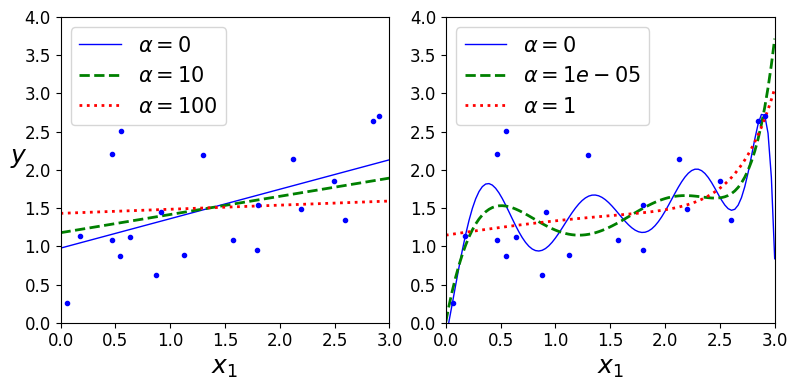

In [24]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

The above figure shows several Ridge models trained on some linear data using different $\alpha$ values. On the left, plain Ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the Ridge models are applied to the resulting features: this is Polynomial Regression with Ridge regularization. 

# Lasso Regression
**L**east **A**bsolute **S**hrinkage and **S**election **O**perator Regression (usually simply called **Lasso Regression**) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the l1 norm of the weight vector instead of half the square of the l2 norm.

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


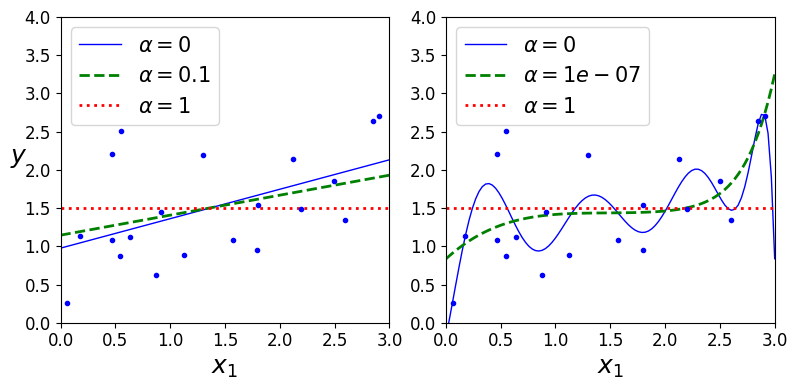

In [25]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the righthand plot in the above figure (with $\alpha = 10^{-7}$) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

In [26]:
# A Lasso regresson example 
# You could also use SGDRegressor(penalty="l1") to achieve Lasso Regression.
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

# Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge
Regression, and when r = 1, it is equivalent to Lasso Regression.

In [27]:
# An ElasticNet example
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Logistic Regression
We are using the "Titanic" dataset in the pyDataset to illustrate Logistic Regression.<br>
For more information, visit:<br>
https://pypi.org/project/pydataset/

In [28]:
# install pydataset if you haven't done so. (remove the comment symbol and run the cell)
# !pip install pydataset

In [29]:
# import the required modules
from pydataset import data
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [30]:
# Get the data
titanic = data('titanic')
titanic.sample(5) # display sample data

,class,age,sex,survived
600,2nd class,child,women,yes
882,3rd class,adults,man,no
635,3rd class,adults,man,yes
426,2nd class,adults,man,no
907,3rd class,adults,man,no


In [31]:
# one hot encoding -- convert categorical data to numerical data for easy handling
titanic = pd.get_dummies(titanic,drop_first=True)
titanic.sample(5)

,class_2nd class,class_3rd class,age_child,sex_women,survived_yes
542,True,False,False,True,True
1134,False,True,False,True,True
182,False,False,False,True,True
333,True,False,False,False,True
41,False,False,False,False,True


In [32]:
# Split data into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(titanic.drop('survived_yes', axis=1), titanic['survived_yes'])

In [33]:
# Train the model using the training data
log_reg = LogisticRegression(solver='lbfgs', random_state=42)
log_reg.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [34]:
# Predicting if a class-1 child-age girl survived
log_reg.predict(np.array([[0,0,1,1]]))[0]

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


True

In [35]:
# Predicting if a class-3 adult-age male survived
log_reg.predict(np.array([[0,1,0,0]]))[0]

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


False

In [36]:
# Check the score of the model. (Accuracy)
log_reg.score(x_test, y_test)

0.7416413373860182

By default, the arrangement of the confusion matrix in sklearn is as follows:<br>
$\begin{bmatrix} TN & FP \\ FN & TP \end{bmatrix}$

In [37]:
y_pred = log_reg.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[170,  39],
       [ 46,  74]])

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(precision)
print(recall)
print(f1)

0.6548672566371682
0.6166666666666667
0.6351931330472103


# Softmax Regression
Let’s use the iris dataset to illustrate Softmax Regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three differentspecies: *Iris setosa*, *Iris versicolor*, and *Iris virginica*.

In [38]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [39]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let’s use Softmax Regression to classify the iris flowers into all three classes. Scikit-Learn’s LogisticRegression uses one-versus-the-rest by default when you train it on more than two classes, but you can set the **multi_class** hyperparameter to "multinomial" to switch it to Softmax Regression. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver (see Scikit-Learn’s documentation for more details). It also applies l2 regularization by default, which you can control using the hyperparameter C. <br>
**Note:** The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha, but its inverse: C. The higher the value of C, the less the model is regularized.

In [40]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


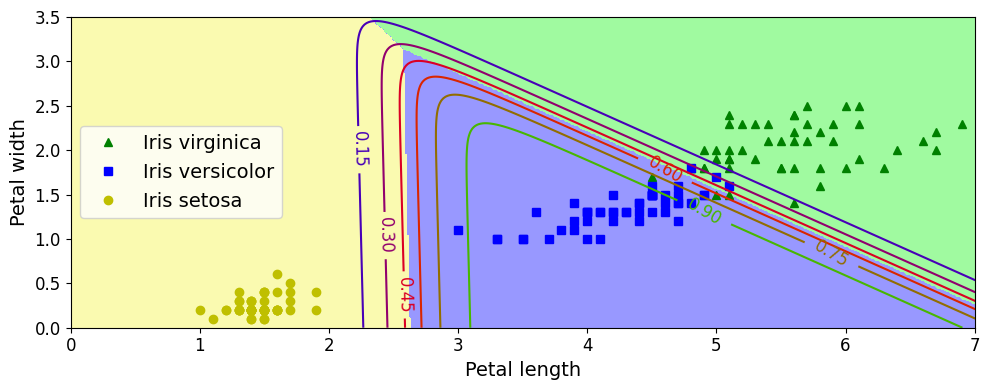

In [41]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

The above figure shows the resulting decision boundaries, represented by the background colors.

In [42]:
softmax_reg.predict([[6, 3]])

array([2])

In [43]:
softmax_reg.predict_proba([[6, 3]])

array([[1.07800854e-13, 1.21573922e-06, 9.99998784e-01]])

In [49]:
predicted_class = softmax_reg.predict([[5 ,2]])
predicted_proba = softmax_reg.predict_proba([[5, 2]])

iris_class = ["Iris setosa", "Iris versicolor", "Iris virginica"]
pred_name = iris_class[predicted_class[0]]
confidence = predicted_proba[0][predicted_class[0]]

print(pred_name)
print(f"prob: {confidence:.2f}")


Iris virginica
prob: 0.94


## Run the program and complete the following exercises. (20 points)
1. (3 points) We have learned two sklearn predefined models that solve linear problems with a regularization term  $\lambda\sum_{i=1}^{n}w_{i}^{2}$ adding to the cost function. What are these models? Provide the function calls for each. 
2. (3 points) how does the hyperparameter $\alpha$ of the Ridge Regression model affect the model's variance and bias?
3. For the Logistic Regression example (Titanic),  
 1. (2 points) When we did "one hot encoding", why did we set "drop_first" to "True"?
 2. (1 points) Briefly explain the command "titanic.drop('survived_yes', axis=1)". (Hint: What did it do? Why do we need it?)
 3. (1 points) In this model, what percentage of data are in the training set and the test set respectly?
 4. (3 points) What were the Precision, Recall, and F1Score for this model? (Show your work)
4. For the Softmax Regression example (Iris),  
 1. (2 points) Is this model regulated? If it is regulated, how?
 2. (2 points) How did we turn the LogisticRegression model to a Softmax model?
 3. (2 points) If you find an iris with petals that are 5cm long and 2cm wide, what type of iris would you expect the model to tell you and with how much confidence (the probability)? (Show your work)
5. (1 points) Create a new Markdown field at the end of this file and put your answers in this field. Submit this file to the Blackboard. 

## Answers

1.
- Ridge Regresssion: 
```
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])
```
- Lasso Regression: 
```
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])
```

2. with a high alpha you have an increased bias and decreased variance. With a low alpha you have a decreased bias and increased variance.

3. N/A

4. (3.1) When one column can be inferred by other columns you can drop it because you can still infer this value in the model so we can drop it.

5. (3.2) It will drop the column that says if they survived. This is because we don't want the model to train based on if they survived since thats what were trying to predict so we dont want to have to know that.

6. (3.3) 25% in the test set and 75% in train

7. (3.4) precision: 0.65\
 recall: 0.62\
 f1: 0.64

8. N/a

9. (4.1) yes its regulated with a value of C=10
10. (4.2) by using "multinomial" and "lbfgs" we can use softmax model.
11. (4.3) Iris virginica with .94 confidence